
# Laboratorio RNN — Partes 2 y 3
Integrantes : 

Mauricio Lemus - 22461
 
Hugo Rivas - 22500

Fuente de datos: fallback sintético (sin statsmodels)


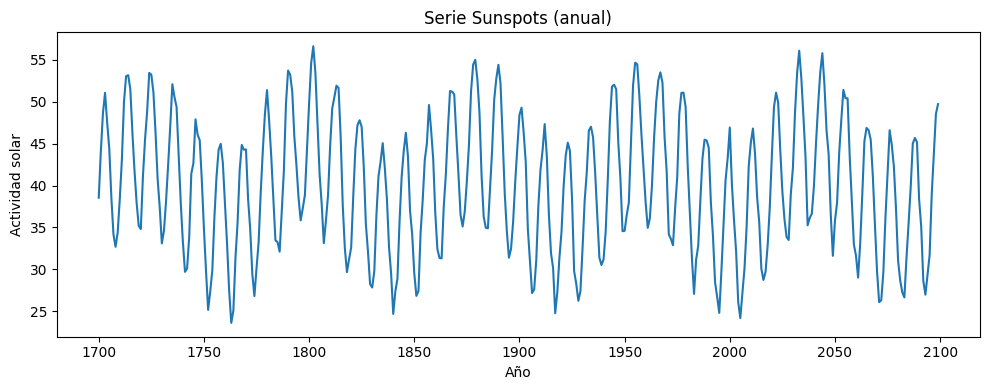

In [1]:

# Imports y utilidades 
import math, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

def load_sunspots_dataframe():
    try:
        import statsmodels.api as sm
        df = sm.datasets.sunspots.load_pandas().data.copy()
        df["YEAR"] = df["YEAR"].astype(int)
        df.rename(columns={"SUNACTIVITY": "value"}, inplace=True)
        df = df[["YEAR", "value"]].reset_index(drop=True)
        src = "statsmodels.api.sunspots (anual)"
        print("Fuente de datos:", src)
        return df
    except Exception:
        rng = np.arange(0, 400)
        y = 40 + 10*np.sin(2*np.pi*rng/11) + 5*np.sin(2*np.pi*rng/80) + np.random.normal(0, 1.0, size=len(rng))
        df = pd.DataFrame({"YEAR": np.arange(1700, 1700+len(rng)), "value": y})
        src = "fallback sintético (sin statsmodels)"
        print("Fuente de datos:", src)
        return df

df = load_sunspots_dataframe()
series = df["value"].values.astype(np.float32)

plt.figure(figsize=(10,4))
plt.plot(df["YEAR"].values, df["value"].values)
plt.title("Serie Sunspots (anual)")
plt.xlabel("Año"); plt.ylabel("Actividad solar")
plt.tight_layout(); plt.show()


In [ ]:

# Partición temporal y normalización Min-Max 
def train_test_split_series(values, train_frac=0.8):
    n = len(values); split = int(n*train_frac)
    return values[:split], values[split:], split

train, test, split_idx = train_test_split_series(series, 0.8)
s_min, s_max = float(np.min(train)), float(np.max(train))

def minmax_scale(x, x_min=s_min, x_max=s_max):
    return (x - x_min) / (x_max - x_min + 1e-8)

def minmax_inverse(x_scaled, x_min=s_min, x_max=s_max):
    return x_scaled * (x_max - x_min + 1e-8) + x_min

train_scaled = minmax_scale(train)
test_scaled  = minmax_scale(test)

print(f"Tamaño total: {len(series)} | Train: {len(train)} | Test: {len(test)}")
print(f"Min/Max train: {s_min:.3f}/{s_max:.3f}")


Tamaño total: 400 | Train: 320 | Test: 80
Min/Max train: 23.619/56.619


In [3]:

# Construcción de ventanas
def make_sequences(arr_1d, window):
    X, y = [], []
    for i in range(window, len(arr_1d)):
        X.append(arr_1d[i-window:i])
        y.append(arr_1d[i])
    X = np.array(X, dtype=np.float32).reshape(-1, window, 1)
    y = np.array(y, dtype=np.float32).reshape(-1, 1)
    return X, y

class SeqDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]


In [4]:

# Modelo RNN y utilidades 
class RNNRegressor(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, num_layers=1, bidirectional=False):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=num_layers, nonlinearity="tanh", batch_first=True, bidirectional=bidirectional)
        out_size = hidden_size * (2 if bidirectional else 1)
        self.fc = nn.Linear(out_size, 1)
    def forward(self, x):
        out, _ = self.rnn(x)        
        last_hidden = out[:, -1, :] 
        return self.fc(last_hidden) 

def evaluate(model, loader, device="cpu"):
    model.eval(); ys, preds = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device); yb = yb.to(device)
            y_hat = model(xb)
            ys.append(yb.cpu().numpy()); preds.append(y_hat.cpu().numpy())
    y = np.vstack(ys).squeeze(); yhat = np.vstack(preds).squeeze()
    y_orig = minmax_inverse(y); yhat_orig = minmax_inverse(yhat)
    mae = float(np.mean(np.abs(y_orig - yhat_orig)))
    rmse = float(np.sqrt(np.mean((y_orig - yhat_orig)**2)))
    mape = float(np.mean(np.abs((y_orig - yhat_orig)/(np.abs(y_orig)+1e-8)))*100)
    return {"MAE": mae, "RMSE": rmse, "MAPE": mape}, y_orig, yhat_orig

def train_rnn_for_window(window, epochs=120, batch_size=64, hidden_size=32, lr=1e-3, device="cpu"):
    X_train, y_train = make_sequences(train_scaled, window)
    X_test,  y_test  = make_sequences(np.concatenate([train_scaled[-window:], test_scaled]), window)

    train_loader = DataLoader(SeqDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
    test_loader  = DataLoader(SeqDataset(X_test,  y_test),  batch_size=batch_size, shuffle=False)

    model = RNNRegressor(1, hidden_size, num_layers=1, bidirectional=False).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    history, grad_norms = [], []
    t0 = time.time()
    for ep in range(1, epochs+1):
        model.train(); ep_losses, ep_grad = [], []
        for xb, yb in train_loader:
            xb = xb.to(device); yb = yb.to(device)
            opt.zero_grad()
            y_hat = model(xb)
            loss = loss_fn(y_hat, yb)
            loss.backward()

            total_norm = 0.0
            for p in model.parameters():
                if p.grad is not None:
                    total_norm += (p.grad.data.norm(2).item())**2
            ep_grad.append(total_norm**0.5)

            opt.step()
            ep_losses.append(loss.item())
        history.append(float(np.mean(ep_losses)))
        grad_norms.append(float(np.mean(ep_grad)))
    train_seconds = time.time() - t0

    metrics, y_true, y_pred = evaluate(model, test_loader, device=device)

    return {
        "window": window,
        "epochs": epochs,
        "train_seconds": train_seconds,
        "history": history,
        "grad_norms": grad_norms,
        "metrics": metrics,
        "y_true": y_true,
        "y_pred": y_pred,
    }



## Parte 2 — Entrenamiento base (ventana = 10)


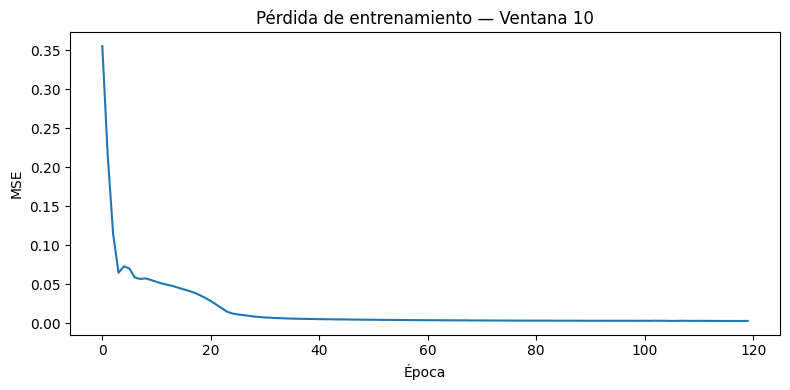

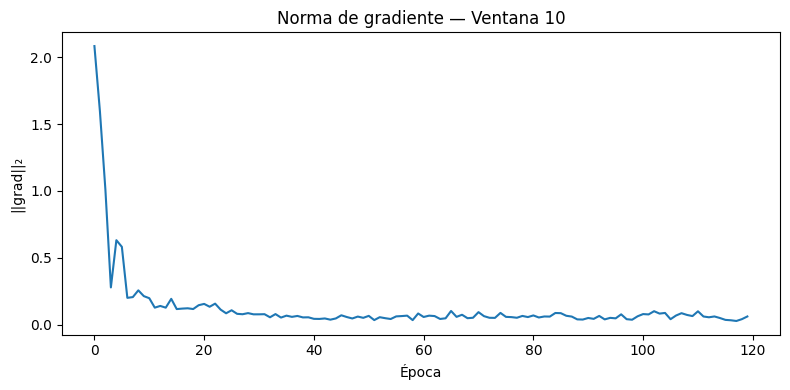

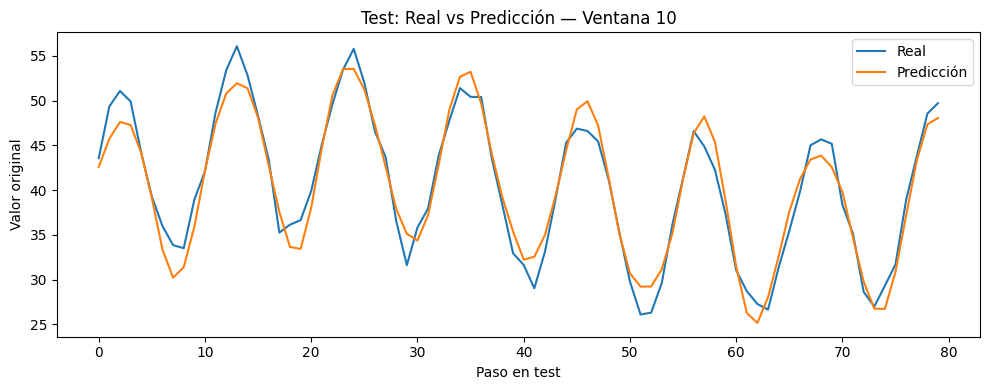

Métricas (ventana=10): {'MAE': 1.602190375328064, 'RMSE': 1.9306625127792358, 'MAPE': 4.17755126953125}
Tiempo de entrenamiento: 2.58 s


In [5]:

DEVICE = "cpu"
BASE_WINDOW = 10
base_result = train_rnn_for_window(window=BASE_WINDOW, epochs=120, batch_size=64, hidden_size=32, lr=1e-3, device=DEVICE)

# Curva de pérdida
plt.figure(figsize=(8,4))
plt.plot(base_result["history"])
plt.title(f"Pérdida de entrenamiento — Ventana {BASE_WINDOW}")
plt.xlabel("Época"); plt.ylabel("MSE"); plt.tight_layout(); plt.show()

# Normas de gradiente
plt.figure(figsize=(8,4))
plt.plot(base_result["grad_norms"])
plt.title(f"Norma de gradiente — Ventana {BASE_WINDOW}")
plt.xlabel("Época"); plt.ylabel("||grad||₂"); plt.tight_layout(); plt.show()

# Real vs predicción (test)
plt.figure(figsize=(10,4))
plt.plot(base_result["y_true"], label="Real")
plt.plot(base_result["y_pred"], label="Predicción")
plt.title(f"Test: Real vs Predicción — Ventana {BASE_WINDOW}")
plt.xlabel("Paso en test"); plt.ylabel("Valor original"); plt.legend(); plt.tight_layout(); plt.show()

print("Métricas (ventana=10):", base_result["metrics"])
print(f"Tiempo de entrenamiento: {base_result['train_seconds']:.2f} s")



## Parte 3 — Experimentos con ventanas (5, 20, 100)


In [6]:

WINDOWS = [5, 20, 100]
results = [base_result]
for w in WINDOWS:
    results.append(train_rnn_for_window(window=w, epochs=120, batch_size=64, hidden_size=32, lr=1e-3, device=DEVICE))

# Tabla comparativa
rows = []
for r in results:
    rows.append({
        "Ventana": r["window"],
        "Épocas": r["epochs"],
        "Train (s)": round(r["train_seconds"], 2),
        "MAE": round(r["metrics"]["MAE"], 3),
        "RMSE": round(r["metrics"]["RMSE"], 3),
        "MAPE (%)": round(r["metrics"]["MAPE"], 2),
        "Grad ||min||": round(float(np.min(r["grad_norms"])), 6),
        "Grad ||max||": round(float(np.max(r["grad_norms"])), 2),
        "Grad ||últ||": round(float(r["grad_norms"][-1]), 2),
    })
summary_df = pd.DataFrame(rows).sort_values("Ventana").reset_index(drop=True)
summary_df


,Ventana,Épocas,Train (s),MAE,RMSE,MAPE (%),Grad ||min||,Grad ||max||,Grad ||últ||
0,5,120,2.26,1.723,2.156,4.46,0.022929,2.05,0.05
1,10,120,2.58,1.602,1.931,4.18,0.027640,2.08,0.06
2,20,120,4.68,1.271,1.506,3.30,0.023510,2.20,0.04
3,100,120,8.69,1.282,1.512,3.32,0.030989,1.52,0.10


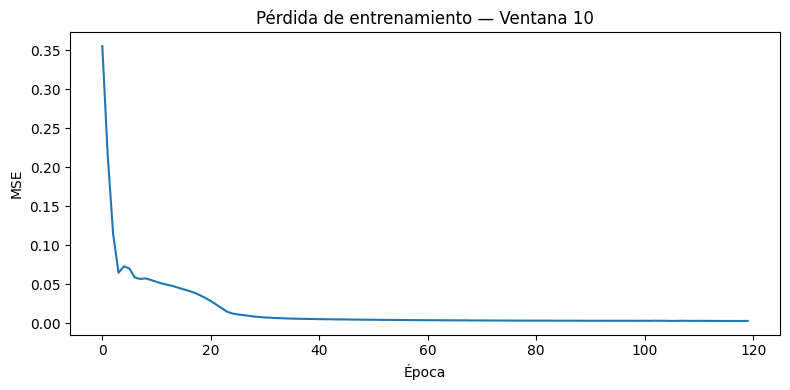

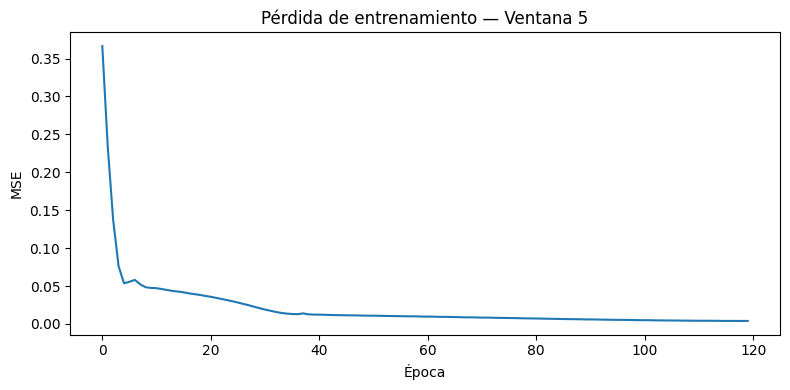

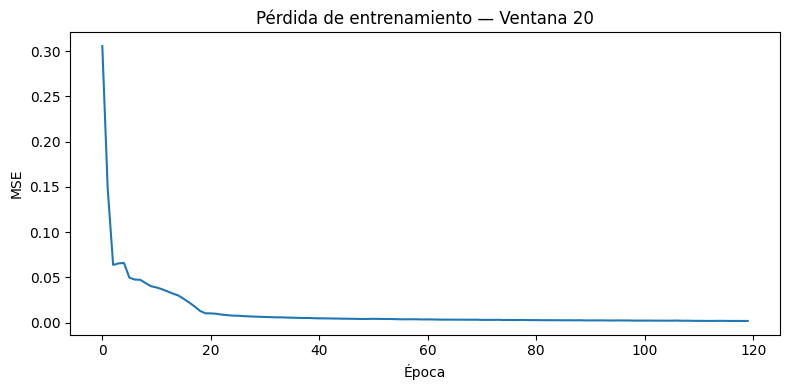

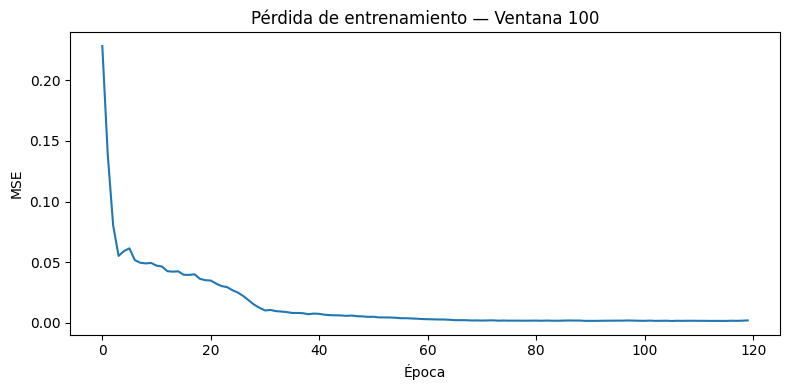

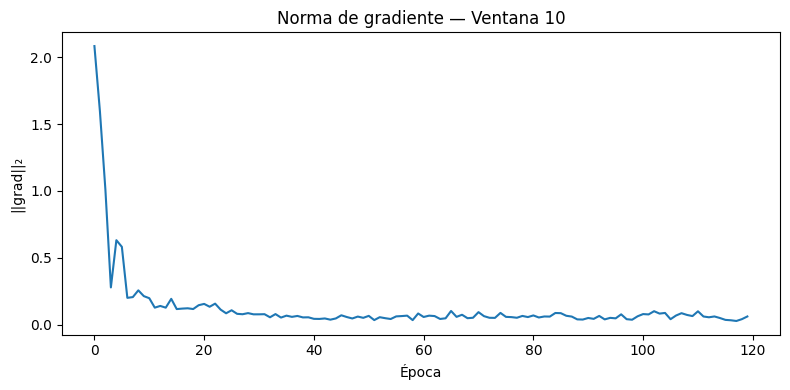

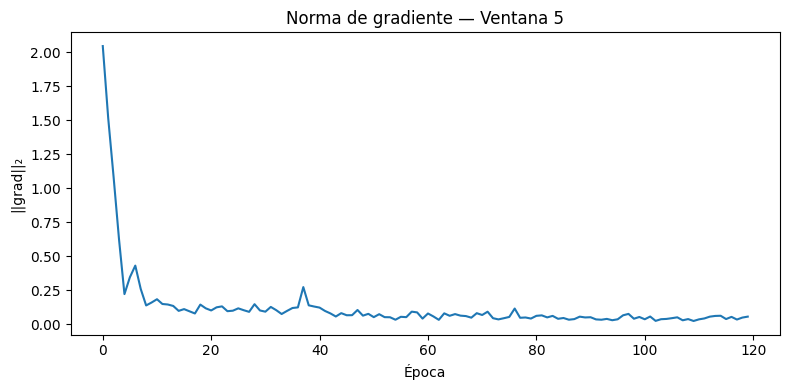

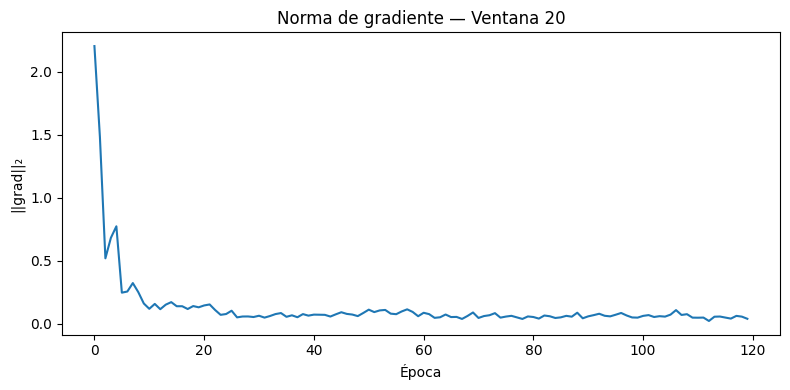

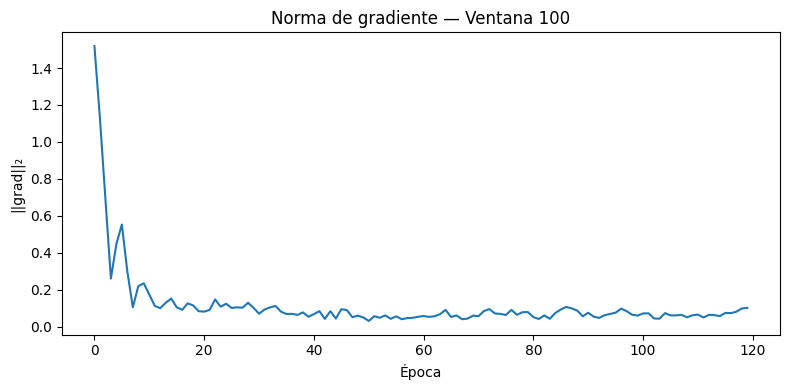

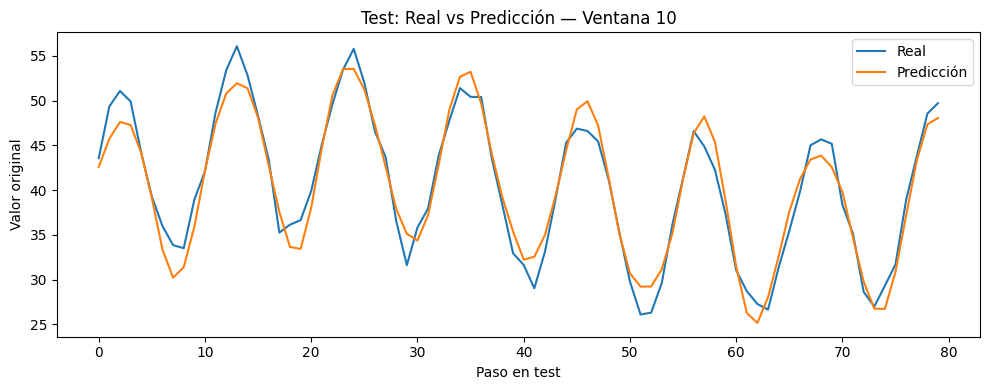

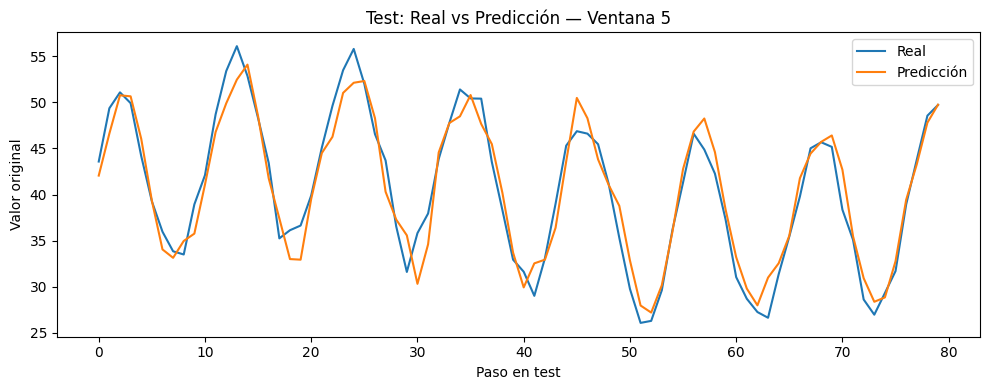

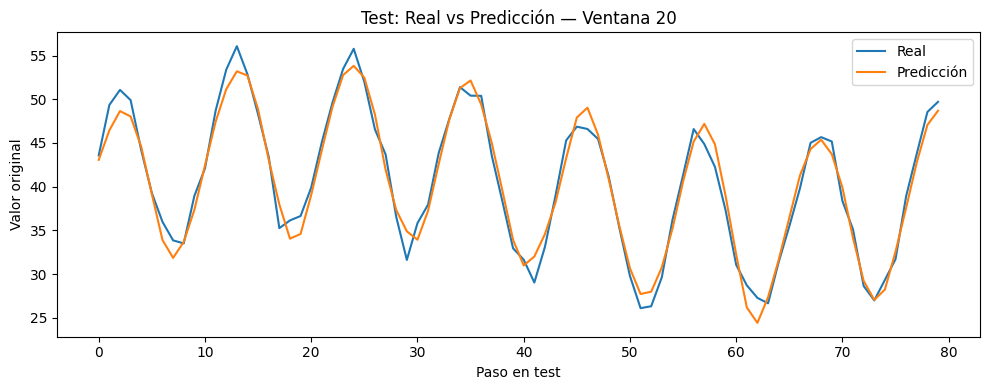

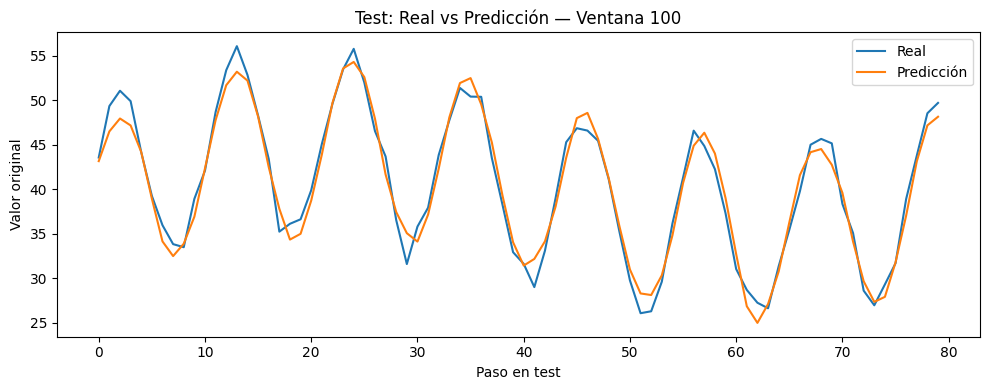

In [7]:

# Curvas de pérdida por ventana
for r in results:
    plt.figure(figsize=(8,4))
    plt.plot(r["history"])
    plt.title(f"Pérdida de entrenamiento — Ventana {r['window']}")
    plt.xlabel("Época"); plt.ylabel("MSE"); plt.tight_layout(); plt.show()

# Normas de gradiente por ventana
for r in results:
    plt.figure(figsize=(8,4))
    plt.plot(r["grad_norms"])
    plt.title(f"Norma de gradiente — Ventana {r['window']}")
    plt.xlabel("Época"); plt.ylabel("||grad||₂"); plt.tight_layout(); plt.show()

# Real vs Predicción por ventana
for r in results:
    plt.figure(figsize=(10,4))
    plt.plot(r["y_true"], label="Real")
    plt.plot(r["y_pred"], label="Predicción")
    plt.title(f"Test: Real vs Predicción — Ventana {r['window']}")
    plt.xlabel("Paso en test"); plt.ylabel("Valor original"); plt.legend(); plt.tight_layout(); plt.show()


In [8]:

def quick_comments(results):
    results = sorted(results, key=lambda r: r["window"])
    lines = []
    for r in results:
        trend = "estable" if np.std(r["grad_norms"]) < 0.5 else "oscilante"
        vanish = np.min(r["grad_norms"]) < 1e-4
        explode = np.max(r["grad_norms"]) > 50
        flags = []
        if vanish: flags.append("vanishing")
        if explode: flags.append("exploding")
        band = " / ".join(flags) if flags else "sin señales fuertes"
        lines.append(f"W={r['window']}: MAE={r['metrics']['MAE']:.2f}, RMSE={r['metrics']['RMSE']:.2f}, MAPE={r['metrics']['MAPE']:.2f}%, grad {trend} ({band}).")
    return "\n".join(lines)

print(quick_comments(results))


W=5: MAE=1.72, RMSE=2.16, MAPE=4.46%, grad estable (sin señales fuertes).
W=10: MAE=1.60, RMSE=1.93, MAPE=4.18%, grad estable (sin señales fuertes).
W=20: MAE=1.27, RMSE=1.51, MAPE=3.30%, grad estable (sin señales fuertes).
W=100: MAE=1.28, RMSE=1.51, MAPE=3.32%, grad estable (sin señales fuertes).
